# Replication code for "The impacts of the Amazon Soy Moratorium on deforestation" 
Heilmayr, Rausch, Munger and Gibbs

## Import packages and define data location

In [1]:
import sys
sys.path.append('D:/dev/glue-sb/')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline 
import numpy as np
import dirfuncs
import plot_tools

In [2]:
dropbox_dir = dirfuncs.guess_dropbox_dir()
data_dir = dropbox_dir + 'soyM/analysis/3-11-20/'

## Set plotting parameters

In [3]:
palette = ['#CD6699', '#448970', '#F5CA7A']
palette = {'notleg': palette[2],
           'notbiom': palette[0],
           'soym': palette[1],
           'neutral': 'black'}
fig_dir = data_dir + 'figures/'
font = {'family' : 'sans-serif',
        'weight': 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

## Load and prep data

In [4]:
defor_csv = data_dir + 'long.csv'
defor_df = pd.read_csv(defor_csv)
# defor_df['on_car'] = np.logical_not(defor_df['propid'].isnull())
# defor_df['gts_car'] = defor_df['gts'].astype(int) & defor_df['on_car']
defor_df['late'] = defor_df['year']>2005

In [153]:
buffer = 300
sample_df = defor_df.loc[((defor_df['dist_amb']>-300) & (defor_df['dist_aml']<300))]

In [154]:
small_buffer = 100
small_sample_df = defor_df.loc[((defor_df['dist_amb']>-small_buffer) & (defor_df['dist_amb']<small_buffer))]

In [155]:
wide_csv = data_dir + 'wide.csv'
wide_df = pd.read_csv(wide_csv)

In [156]:
sample_df.loc[:,'gaez_soy_suit'] = (sample_df['GAEZsuit']>40).astype(int)
sample_df.loc[:,'soy_suit'] = ((sample_df['gaez_soy_suit']==1) & (sample_df['suit']>0)).astype(int)
small_sample_df.loc[:,'gaez_soy_suit'] = (small_sample_df['GAEZsuit']>40).astype(int)
small_sample_df.loc[:,'soy_suit'] = ((small_sample_df['gaez_soy_suit']==1) & (small_sample_df['suit']>0)).astype(int)
wide_df.loc[:,'gaez_soy_suit'] = (wide_df['GAEZsuit']>40).astype(int)
wide_df.loc[:,'soy_suit'] = ((wide_df['gaez_soy_suit']==1) & (wide_df['suit']>0)).astype(int)
suit_var = 'soy_suit'

In [10]:
soy_csv = data_dir + 'soy_conversion.csv'
soy_df = pd.read_csv(soy_csv)

FileNotFoundError: [Errno 2] File b'D:/cloud/dropbox/collaborations/glue-sb/soyM/analysis/3-11-20/soy_conversion.csv' does not exist: b'D:/cloud/dropbox/collaborations/glue-sb/soyM/analysis/3-11-20/soy_conversion.csv'

## Figure 2 - Primary trend comparison

In [157]:
out_var = 'mb2_vdefor'
defor = pd.pivot_table(sample_df, columns = 'year', index = [suit_var, 'biome', 'legal_amazon'], values = out_var, 
                       aggfunc = 'sum')
forest = pd.pivot_table(sample_df, columns = 'year', index = [suit_var, 'biome', 'legal_amazon'], values = out_var, 
                        aggfunc = 'count')
defor_shr = ((defor / forest) * 100).dropna(axis = 1).T.loc[2002:2016]
defor_shr = defor_shr.T

In [159]:
def clean_time(time_csv):
    time_df = pd.read_csv(time_csv)
    time_df = time_df.iloc[1:-1]
    time_df.columns = ['var', 'estimate']
    time_df.loc[:,'var'] = np.repeat(time_df['var'].dropna(), 2).values
    time_df.loc[:,'stat'] = np.tile(['coef', 'ci'], int((time_df.shape[0]/2)))
    time_df = time_df.set_index(['stat', 'var'])
    time_df = time_df.unstack().T.reset_index()
    soy_rows = [var for var in time_df['var'] if (suit_var in var) & ('biome' in var) & ('year' in var)]
    df = time_df.loc[time_df['var'].isin(soy_rows)]
    df.loc[:,'year'] = df['var'].apply(lambda x: int(x[:4]))
    df.loc[:,'coef'] = df['coef'].apply(lambda x: float(x)) * 100
    df.loc[:,'lb'] = df['ci'].apply(lambda x: float(x.split(',')[0])) * 100
    df.loc[:,'ub'] = df['ci'].apply(lambda x: float(x.split(',')[1])) * 100
    df.loc[:,'err'] = df.loc[:,'coef'] - df.loc[:,'lb']
    return df


In [160]:
time_csv = data_dir + 'figures/f2_time_plot.csv'
soytime_df = clean_time(time_csv)

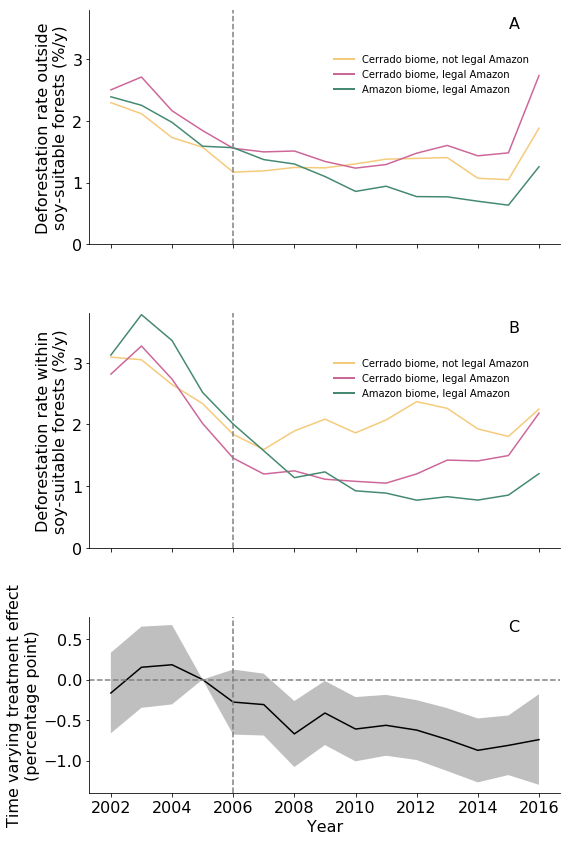

In [161]:
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 2, 1.5]) 
fig = plt.figure(figsize=(8,12))
ax2 = plt.subplot(gs[2])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0, sharey = ax0)
ax0.plot(defor_shr.columns, defor_shr.loc[(0,0,0)], color = palette['notleg'], linestyle = '-')
ax0.plot(defor_shr.columns, defor_shr.loc[(0,0,1)], color = palette['notbiom'], linestyle = '-')
ax0.plot(defor_shr.columns, defor_shr.loc[(0,1,1)], color = palette['soym'], linestyle = '-')
ax1.plot(defor_shr.columns, defor_shr.loc[(1,0,0)], color = palette['notleg'], linestyle = '-')
ax1.plot(defor_shr.columns, defor_shr.loc[(1,0,1)], color = palette['notbiom'], linestyle = '-')
ax1.plot(defor_shr.columns, defor_shr.loc[(1,1,1)], color = palette['soym'], linestyle = '-')
sns.despine()
handles = [plt.Line2D(range(10), range(10), linestyle='-', color = palette['notleg'], linewidth = 2),
           plt.Line2D(range(10), range(10), linestyle='-', color = palette['notbiom'], linewidth = 2),
           plt.Line2D(range(10), range(10), linestyle='-', color = palette['soym'], linewidth = 2)]
ax0.set_ylabel('Deforestation rate outside\nsoy-suitable forests (%/y)')
ax1.set_ylabel('Deforestation rate within\nsoy-suitable forests (%/y)')
ax2.set_xlabel('Year')
ax0.axvline(x = 2006, color = 'grey', linestyle = '--')
ax1.axvline(x = 2006, color = 'grey', linestyle = '--')
labels = ['Cerrado biome, not legal Amazon', 'Cerrado biome, legal Amazon', 'Amazon biome, legal Amazon']
ax2.set_ylabel('Time varying treatment effect\n(percentage point)')
ax2.plot(soytime_df['year'].values, soytime_df['coef'].values, color = 'black')
ax2.fill_between(soytime_df['year'], soytime_df['lb'], soytime_df['ub'], alpha = 0.5, facecolor='grey', interpolate=False)
ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax0.set_ylim((0,3.8))
ax2.axvline(x = 2006, color = 'grey', linestyle = '--')
ax2.axhline(y = 0, color = 'grey', linestyle = '--')
sns.despine()
ax0.annotate("A", xy = (2015, 3.5))
ax1.annotate("B", xy = (2015, 3.5))
ax2.annotate("C", xy = (2015, 0.6))
lgd = ax0.legend(handles, labels, fontsize = 10, frameon = False, loc='lower left', bbox_to_anchor=(0.5, 0.6))
lgd = ax1.legend(handles, labels, fontsize = 10, frameon = False, loc='lower left', bbox_to_anchor=(0.5, 0.6))
fig.tight_layout()
fig.savefig(data_dir + 'figures/f2_summary.svg')

# Figure S4 - Spatially bounded version of Figure 2

In [162]:
out_var = 'mb2_vdefor'
small_sample_df.loc[:,'soy_suit'] = ((small_sample_df['gaez_soy_suit']==1) & (small_sample_df['suit']>0)).astype(int)
defor = pd.pivot_table(small_sample_df, columns = 'year', index = [suit_var, 'biome', 'legal_amazon'], values = out_var, 
                       aggfunc = 'sum')
forest = pd.pivot_table(small_sample_df, columns = 'year', index = [suit_var, 'biome', 'legal_amazon'], values = out_var, 
                        aggfunc = 'count')
defor_shr = ((defor / forest) * 100).dropna(axis = 1).T.loc[2002:2016]
defor_shr = defor_shr.T
time_csv = data_dir + 'figures/f2_time_plot_100.csv'
soytime_df = clean_time(time_csv)

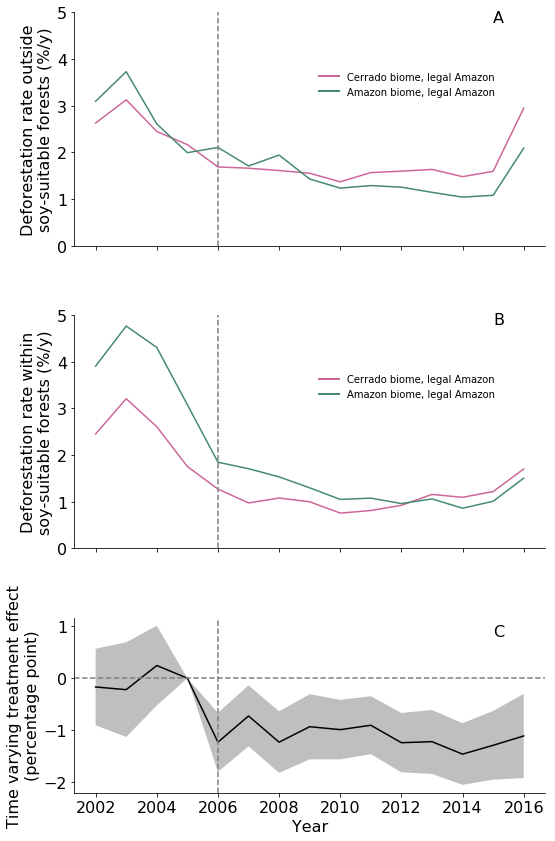

In [163]:
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 2, 1.5]) 
fig = plt.figure(figsize=(8,12))
ax2 = plt.subplot(gs[2])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0, sharey = ax0)
ax0.plot(defor_shr.columns, defor_shr.loc[(0,0,1)], color = palette['notbiom'], linestyle = '-')
ax0.plot(defor_shr.columns, defor_shr.loc[(0,1,1)], color = palette['soym'], linestyle = '-')
ax1.plot(defor_shr.columns, defor_shr.loc[(1,0,1)], color = palette['notbiom'], linestyle = '-')
ax1.plot(defor_shr.columns, defor_shr.loc[(1,1,1)], color = palette['soym'], linestyle = '-')
sns.despine()
handles = [plt.Line2D(range(10), range(10), linestyle='-', color = palette['notbiom'], linewidth = 2),
           plt.Line2D(range(10), range(10), linestyle='-', color = palette['soym'], linewidth = 2)]
ax0.set_ylabel('Deforestation rate outside\nsoy-suitable forests (%/y)')
ax1.set_ylabel('Deforestation rate within\nsoy-suitable forests (%/y)')
ax2.set_xlabel('Year')
ax0.axvline(x = 2006, color = 'grey', linestyle = '--')
ax1.axvline(x = 2006, color = 'grey', linestyle = '--')
labels = ['Cerrado biome, legal Amazon', 'Amazon biome, legal Amazon']
ax2.set_ylabel('Time varying treatment effect\n(percentage point)')
ax2.plot(soytime_df['year'].values, soytime_df['coef'].values, color = 'black')
ax2.fill_between(soytime_df['year'], soytime_df['lb'], soytime_df['ub'], alpha = 0.5, facecolor='grey', interpolate=False)
ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax0.set_ylim((0,5))
ax2.axvline(x = 2006, color = 'grey', linestyle = '--')
ax2.axhline(y = 0, color = 'grey', linestyle = '--')
sns.despine()
ax0.annotate("A", xy = (2015, 4.8))
ax1.annotate("B", xy = (2015, 4.8))
ax2.annotate("C", xy = (2015, 0.8))
lgd = ax0.legend(handles, labels, fontsize = 10, frameon = False, loc='lower left', bbox_to_anchor=(0.5, 0.6))
lgd = ax1.legend(handles, labels, fontsize = 10, frameon = False, loc='lower left', bbox_to_anchor=(0.5, 0.6))
fig.tight_layout()
fig.savefig(data_dir + 'figures/fs2_summary.svg')

## Figure 3 - Soy establishment trends

In [164]:
soy_df = soy_df.loc[(soy_df['dist_amb']>-300) & (soy_df['dist_aml']<300)]
soy_subset = soy_df.loc[soy_df['a_start_soy']==0]

NameError: name 'soy_df' is not defined

In [ ]:
soy_subset.loc[(soy_subset['year']==2017) & (soy_subset['biome']==1), 'mb_start_for'].value_counts()

In [ ]:
soy_subset.loc[(soy_subset['year']==2017) & (soy_subset['biome']==1) & (soy_subset['mb_start_for']==0), 'a_soy'].value_counts()

In [ ]:
summary_df = pd.pivot_table(soy_subset, index = 'a_soy', 
                            columns = ['year', 'mb_start_for', 'legal_amazon', 'biome'], values = 'ptid', aggfunc = len)
convert_df = (summary_df.loc[1] / (summary_df.loc[0] + summary_df.loc[1])).unstack(level=0)*100
convert_df = convert_df.rename(columns = {2006: '2000-2006', 2017: '2007-2017'})

In [ ]:
convert_df

In [ ]:
fig, ax = plt.subplots()
ax.plot(convert_df.loc[(0,0,0)], marker = 'o', linestyle = '--', color = palette['notleg'])
ax.plot(convert_df.loc[(0,1,0)], marker = 'o', linestyle = '--', color = palette['notbiom'])
ax.plot(convert_df.loc[(0,1,1)], marker = 'o', linestyle = '--', color = palette['soym'])
ax.plot(convert_df.loc[(1,0,0)], marker = 'o', linestyle = '-', color = palette['notleg'])
ax.plot(convert_df.loc[(1,1,0)], marker = 'o', linestyle = '-', color = palette['notbiom'])
ax.plot(convert_df.loc[(1,1,1)], marker = 'o', linestyle = '-', color = palette['soym'])
ax.set_ylabel('Percent of area\nconverted to soy')
ax.set_xlabel('Time period')
ax.set_xlim((-0.2, 1.2))

sns.despine()
handle_len = 50
handles = [plt.Line2D(range(handle_len), range(handle_len), linestyle='-', color = palette['notleg'], linewidth = 2),
           plt.Line2D(range(handle_len), range(handle_len), linestyle='-', color = palette['notbiom'], linewidth = 2),
           plt.Line2D(range(handle_len), range(handle_len), linestyle='-', color = palette['soym'], linewidth = 2)]
labels = ['Cerrado biome,\noutside legal Amazon', 'Cerrado biome,\nlegal Amazon', 'Amazon\nbiome']
lgd1 = ax.legend(handles, labels, fontsize = 8, frameon = False, loc = "upper left", bbox_to_anchor=(1.15,.9), handlelength = 4)
handles = [plt.Line2D(range(handle_len), range(handle_len), linestyle='--', color = palette['notleg'], linewidth = 2),
           plt.Line2D(range(handle_len), range(handle_len), linestyle='--', color = palette['notbiom'], linewidth = 2),
           plt.Line2D(range(handle_len), range(handle_len), linestyle='--', color = palette['soym'], linewidth = 2)]
labels = ['\n', '\n', '\n']
lgd2 = ax.legend(handles, labels, fontsize = 8, frameon = False, loc = "upper left", bbox_to_anchor=(1.,.9), handlelength=4)
ax.add_artist(lgd1)
ax.add_artist(lgd2)
ax.annotate('Non-forested\nlocations', xy = (1.075, 0.90), xycoords = "axes fraction", fontsize = 8, ha="center")
ax.annotate('Forested\nlocations', xy = (1.225, 0.90), xycoords = "axes fraction", fontsize = 8, ha="center")
fig.savefig(data_dir + 'figures/f3_conversion.svg', bbox_inches = 'tight')

## Create Figure S1 - Comparison to full Amazon

In [ ]:
defor = pd.pivot_table(sample_df, columns = 'year', index = ['biome', 'legal_amazon'], values = out_var, 
                       aggfunc = 'sum')
forest = pd.pivot_table(sample_df, columns = 'year', index = ['biome', 'legal_amazon'], values = out_var, 
                        aggfunc = 'count')
defor_shr = ((defor / forest) * 100).dropna(axis = 1).T.loc[2002:2016]
defor_shr = defor_shr.T
defor_all = pd.pivot_table(defor_df, columns = 'year', index = ['biome', 'legal_amazon'], values = out_var, 
                       aggfunc = 'sum')
forest_all = pd.pivot_table(defor_df, columns = 'year', index = ['biome', 'legal_amazon'], values = out_var, 
                        aggfunc = 'count')
defor_shr_all = ((defor_all / forest_all) * 100).dropna(axis = 1).T.loc[2002:2016]
defor_shr_all = defor_shr_all.T

In [ ]:
gs = gridspec.GridSpec(1, 2) 
fig = plt.figure(figsize=(15,4))
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0, sharey = ax0)
ax0.plot(defor_shr.columns, defor_shr_all.loc[(0, 0)], color = palette['notleg'], linestyle = '-')
ax0.plot(defor_shr.columns, defor_shr_all.loc[(0, 1)], color = palette['notbiom'], linestyle = '-')
ax0.plot(defor_shr.columns, defor_shr_all.loc[(1, 1)], color = palette['soym'], linestyle = '-')
ax1.plot(defor_shr.columns, defor_shr.loc[(0, 0)], color = palette['notleg'], linestyle = '-')
ax1.plot(defor_shr.columns, defor_shr.loc[(0, 1)], color = palette['notbiom'], linestyle = '-')
ax1.plot(defor_shr.columns, defor_shr.loc[(1, 1)], color = palette['soym'], linestyle = '-')
sns.despine()
handles = [plt.Line2D(range(10), range(10), linestyle='-', color = palette['notleg'], linewidth = 2),
           plt.Line2D(range(10), range(10), linestyle='-', color = palette['notbiom'], linewidth = 2),
           plt.Line2D(range(10), range(10), linestyle='-', color = palette['soym'], linewidth = 2)]
ax0.set_ylabel('Deforestation rate (%/y)')
ax0.set_xlabel('Year')
ax1.set_xlabel('Year')
ax0.axvline(x = 2006.5, color = 'grey', linestyle = '--')
ax1.axvline(x = 2006.5, color = 'grey', linestyle = '--')
labels = ['Cerrado biome, not legal Amazon', 'Cerrado biome, legal Amazon', 'Amazon biome, legal Amazon']
lgd = ax1.legend(handles, labels, fontsize = 8, frameon = False)
ax0.set_title("Full Amazon and Cerrado biomes")
ax1.set_title("Restricted Amazon and Cerrado biomes")
sns.despine()
fig.tight_layout()
ax0.xaxis.set_ticks(np.arange(2002, 2018, 2))
fig.savefig(data_dir + 'figures/methods_s1.svg')

## Paper calculations
### Impact calculations

In [165]:
out_var = 'mb2_vdefor'
defor = pd.pivot_table(sample_df, columns = 'year', index = ['soy_suit', 'biome', 'legal_amazon'], values = out_var, 
                       aggfunc = 'sum')
start_forest = pd.pivot_table(sample_df, columns = 'year', index = ['soy_suit', 'biome', 'legal_amazon'], values = out_var, 
                        aggfunc = 'count')
defor_shr = ((defor / start_forest) * 100).dropna(axis = 1).T.loc[2002:2016]
defor_shr = defor_shr.T

In [268]:
att = -0.0064 # From Table 1, column 5
se = 0.00163
ci = 1.96 * se
print(ci)

0.0031948


In [272]:
bl_defor = (100-defor_shr.loc[(1,1,1), 2006:])/100
bl_cumdefor = bl_defor.cumprod().loc[2016]
start_for_05 = start_forest.loc[(1,1,1), 2006]
bl_forests = start_for_05 * bl_cumdefor
total_defor = (start_forest.loc[(1,1,1), 2006] - start_forest.loc[(1,1,1), 2017]) * 4

att_draw = np.random.normal(att, se, 10000)
cf_forests = pd.Series(map(lambda att: start_for_05 * ((att + bl_defor).cumprod().loc[2016]), att_draw))
avoided_defor = (bl_forests - cf_forests) * 4
mean = np.mean(avoided_defor)
std = np.std(avoided_defor)
ci = std * 1.96

In [273]:
print("ASM saved " + str(int(mean)) + ' +/- ' + str(ci) + ' km2 of forests')
pct_reduction = mean / (total_defor + mean)
pct_reduction_ci = ci / (total_defor + mean)
print("ASM reduced total deforestation by " + str(int(100*pct_reduction)) + ' +/- ' + str(int(100*pct_reduction_ci)) + " percent")

ASM saved 17719 +/- 8708.447843822312 km2 of forests
ASM reduced total deforestation by 34 +/- 16 percent


In [18]:
out_var = 'mb2_vdefor'
defor = pd.pivot_table(sample_df, columns = 'year', index = ['biome', 'legal_amazon'], values = out_var, 
                       aggfunc = 'sum')
start_forest = pd.pivot_table(sample_df, columns = 'year', index = ['biome', 'legal_amazon'], values = out_var, 
                        aggfunc = 'count')
defor_shr = ((defor / start_forest) * 100).dropna(axis = 1).T.loc[2002:2016]
defor_shr = defor_shr.T
defor_shr.loc[1,1]

year
2002    2.757771
2003    3.014041
2004    2.660198
2005    2.045254
2006    1.780413
2007    1.469617
2008    1.220725
2009    1.162376
2010    0.888757
2011    0.913861
2012    0.771697
2013    0.797305
2014    0.734175
2015    0.740342
2016    1.229487
Name: (1, 1), dtype: float64

### Complementarities with public policies
In addition, our estimate of the impact of the ASM represents only 25 percent of the 2.6 pp reduction in deforestation rates that occurred between 2002 and 2016 on soy-suitable locations in the Amazon biome portion of the Arc of Deforestation.

In [81]:
reduction = (defor_shr.loc[(1,1,1)][2003] - defor_shr.loc[(1,1,1)][2016])
print(reduction)

2.5775838107536533


In [82]:
att * -100 / reduction

0.2482945451976873

### Research design
Since 90 percent of soy is planted in locations that meet specific soil and climatic suitability conditions, 

In [35]:
subset = wide_df.loc[(wide_df['dist_amb']>-buffer) & (wide_df['dist_aml']<buffer)]
suit_df = subset.pivot_table(index = 'a_soy_2017', columns = suit_var, values = 'ptid', aggfunc = len).loc[1]
suit_df[[1,2]].sum() / suit_df.sum()

0.8951466817230104

### Avoided deforestation
Prior to the adoption of the ASM, deforestation rates were similar on soy-suitable lands across the Amazon biome (XX% per year), the Cerrado-portion of the Legal Amazon (XX% per year) as well as the portion of the Cerrado biome outside of the Legal Amazon (XX% per year). Between 2006 and 2016, soy-suitable deforestation rates in the Amazon biome fell to XX%/year, XX pp/year below the rate of soy-suitable deforestation in the Cerrado portion of the Legal Amazon and XX pp/year below the rate in the Cerrado biome outside of the legal Amazon. 

In [86]:
defor = pd.pivot_table(sample_df.loc[sample_df['soy_suit']==1], columns = 'year', index = ['biome', 'legal_amazon'], values = 'mb2_vdefor', 
                       aggfunc = 'sum')
forest = pd.pivot_table(sample_df.loc[sample_df['soy_suit']==1], columns = 'year', index = ['biome', 'legal_amazon'], values = 'mb2_vdefor', 
                        aggfunc = 'count')
defor_shr = ((defor / forest) * 100).dropna(axis = 1).T.loc[2002:2017]
defor_shr = defor_shr.T
defor_shr[list(range(2002, 2006))].mean(axis = 1)

biome  legal_amazon
0      0               2.780932
       1               2.709260
1      0               0.467290
       1               3.195651
dtype: float64

In [88]:
p2_rates = defor_shr[list(range(2006, 2017))].mean(axis = 1)
p2_rates

biome  legal_amazon
0      0               1.996282
       1               1.349211
1      0               0.351380
       1               1.107928
dtype: float64

In [89]:
p2_rates.loc[(0,1)] - p2_rates.loc[(1,1)]

0.2412832234781781

In [90]:
p2_rates.loc[(0,0)] - p2_rates.loc[(1,1)]

0.888354110620238

## Methods calculations
### Study region
This region captures 96 percent of the 2017 soy area in the Amazon biome as well as 96 percent of the area of forests converted to soy between 2000 and 2017. In addition, our study region contains almost all (94 percent) of the forests monitored by the Soy Working Group (GTS) between 2007 and 2014. 

In [98]:
defor_df['arc'] = (defor_df['dist_amb']>-300) & (defor_df['dist_aml']<300)

In [99]:
defor = pd.pivot_table(defor_df.loc[defor_df['biome']==1], columns = 'year', 
                       index = 'arc', values = 'a_soy_2017', aggfunc = 'sum')
defor = defor.sum(axis = 1)
defor[True] / defor.sum()

0.9621263974446727

In [100]:
soy_defor = pd.pivot_table(defor_df.loc[(defor_df['biome']==1) & (defor_df['a_soy_2017']==1)], columns = 'year', 
                       index = 'arc', values = 'mb2_vdefor', aggfunc = 'sum')
soy_defor = soy_defor.sum(axis = 1)
soy_defor[True] / soy_defor.sum()

0.9623817216708977

In [101]:
subset = defor_df.loc[(defor_df['mb2_vfor_2000']==1) & (defor_df['year']<2015)]
ever_gts = subset.pivot_table(index = 'ptid', values = 'gts', aggfunc = max)
ever_arc = subset.pivot_table(index = 'ptid', values = 'arc', aggfunc = max)
ever_gts = ever_gts.merge(ever_arc, left_index = True, right_index = True, how = 'left')
ctab = pd.crosstab(ever_gts['gts'], ever_gts['arc'])
ctab.loc[1, True] / ctab.loc[1].sum()

0.9442789242404616

### Sample creation
Across our study region, we sampled observations at each vertex of a grid of evenly spaced (2km) horizontal and vertical lines. This produced XX sample points with XX of those points falling inside the Amazon biome and XX points falling inside the Cerrado biome.  For each of these points, we extracted data from a variety of sources as outlined below.

In [188]:
subset = wide_df.loc[(wide_df['dist_amb']>-buffer) & (wide_df['dist_aml']<buffer)]
pt_description = subset.pivot_table(index = ['biome'], columns = 'mb2_vfor_2000', values = 'ptid', aggfunc = len)

In [189]:
pt_description.sum().sum()

463466

In [190]:
pt_description.sum(axis = 1)

biome
0    278847
1    184619
dtype: int64

In [ ]:

defor = sample_df.pivot_table(index = ['legal_amazon', 'biome'], columns = 'late', values = 'mb2_vdefor', aggfunc = np.sum)
start_for = sample_df.pivot_table(index = ['legal_amazon', 'biome'], columns = 'year', values = 'mb2_vdefor', aggfunc = 'count')[2007]
defor_rates = (defor[True] / start_for) / 10

In [29]:
defor_rates[(0,0)] - defor_rates[(1,1)]

0.0064024806478438206

### Functional form
However, given that annual deforestation events are relatively rare (mean annual deforestation = XX), a non-linear functional form might better represent our binary outcome variable. To test whether our results are robust to changes in the functional form of our model, we re-ran our primary model specification using a logistic regression. We found that the two models yielded similar results (Table D, Column 5). While our linear probability model indicates the ASM caused an XX percent reduction in deforestation, the odds ratio of the logistic regression indicates the ASM has caused an XX percent reduction in deforestation.

In [197]:
out_var = 'mb2_vdefor'
defor = pd.pivot_table(sample_df, columns = 'year', index = ['legal_amazon'], values = out_var, 
                       aggfunc = 'sum')
forest = pd.pivot_table(sample_df, columns = 'year', index = ['legal_amazon'], values = out_var, 
                        aggfunc = 'count')
defor_shr = ((defor / forest) * 100).dropna(axis = 1).T.loc[2002:2016]
defor_shr[1].mean()

1.5815028284185186

### Point and property fixed effects
To estimate this model we restricted our sample to the XX percent of points that fell within a property listed in one of the state or federal registries. 

In [147]:
subset = wide_df.loc[(wide_df['dist_amb']>-buffer) & (wide_df['dist_aml']<buffer)]
(subset['propid'].notnull()).astype(int).describe()['mean']

0.56961891487185679